## 🔧 Gmail Job Scanner Web App for Mechanical Fitter Roles

This Jupyter Notebook automates the end-to-end process of identifying FIFO shutdown job opportunities for mechanical fitters directly from your Gmail inbox.

### 🚀 Key Features

This app performs the following steps:

1. **Authenticate with Gmail & Google Calendar**
   Securely connects to your Gmail and Calendar using OAuth 2.0 or token-based authentication.

2. **Scan Recent Emails**
   Searches your inbox for new or unread emails that may contain job listings.

3. **Classify with OpenAI GPT**
   Uses an OpenAI language model to analyze each email and determine whether it includes a mechanical fitter job offer.

4. **Extract Structured Job Info**
   Parses the email content to pull out key information such as:
   * Worksite / Company
   * Start and end dates
   * Pay rates
   * Clean shaven policies at the worksite
   
   

5. **Store Valid Job Offers**
   Compiles confirmed job offers into a structured list for easy tracking and debugging.

6. **Add Jobs to Google Calendar**
   Automatically inserts valid job offers as calendar events with all relevant details.
   
7. **Add Jobs to Google Sheets spreadsheet**
   Record all job offers in a spreadsheet for real time and future data analysis.

---

<a id="shut-up"></a>
# SHUT UP AND JUST RUN IT?? 
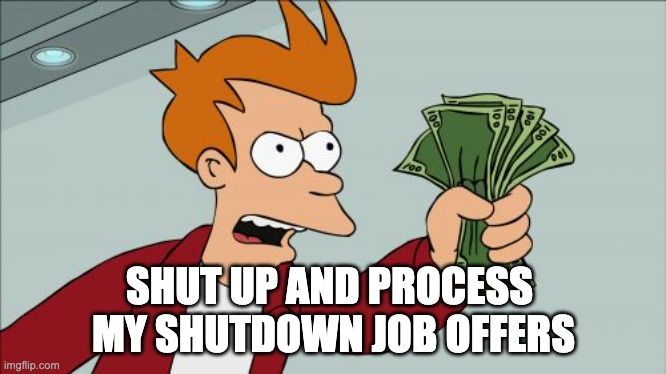

Slow down tiger... you will need to get your private keys first:
1. Google OAuth: Access to your Gmail, Calendar and Spreadsheets [Follow this](#google-auth)
2. OpenAPI key: **not free 😢** Every time you use the GPT model it will charge you some credits [Follow this](#openai-auth)
3. Calendar ID: Tell it what calendar to put the events in. [Follow this](#cal-id)
4. Spreadsheet ID: Tell it where to record your job entries. [Follow this](#spreadsheet-id)

Once you have all these, you are ready to run it. Edit the [main program](#main-section) if desired, then click Toolbar: `Cell` > `Run All`

## 📦 Step 1: Install Required Python Packages

Before running the notebook, make sure all necessary Python libraries are installed. These packages allow the script to authenticate with Google APIs, interact with Gmail and Google Calendar, call the OpenAI API, and manage environment variables securely.
### 📄 `requirements.txt`

Create a file named `requirements.txt` and add the following content:

```
google-api-python-client
google-auth
google-auth-oauthlib
google-auth-httplib2
openai
requests
python-dotenv
bs4
pytz
```

You can install all dependencies with:

```bash
pip install --upgrade -r requirements.txt
```
Or install for python for your specific environment, e.g. if using anaconda, you may need to run something like:
``` bash
/Users/dd/opt/anaconda3/bin/python -m pip install --upgrade -r requirements.txt
```
---

## ⚙️ GitHub Actions: Install Python Packages

In your GitHub Actions workflow `.yaml` file (e.g., `.github/workflows/gmail_job_pipeline.yml`), ensure the following step is included to install the dependencies:

```yaml
- name: Install dependencies
  run: |
    python -m pip install --upgrade pip
    pip install -r requirements.txt
```

> ✅ This ensures that GitHub Actions uses the exact same packages as your local or Colab setup.

#### _The full .yaml file will be included at the end of this notebook_

---

## 🔐 Step 2: Authenticate to Gmail and Google Calendar

To access Gmail, Google Calendar and Sheets via the Google APIs, you need to authenticate using **OAuth 2.0**. This allows the app to read emails and create calendar events on your behalf securely.

There are **two modes of authentication** depending on your environment:

---

<a id="google-auth"></a>
### 🔹 Local Mode (Interactive)
[Go back to the top](#shut-up)

If you're running the script locally:

1. **Enable APIs:**

   * Go to the [Google Cloud Console](https://console.cloud.google.com/apis/dashboard).
   * Create a new project (or select an existing one).
   * Enable both the **Gmail API**, **Google Calendar API** and **Google Sheets API**

2. **Create OAuth Credentials:**

   * Go to **APIs & Services > Credentials**.
   * Click **"Create Credentials" > OAuth Client ID**.
   * Choose **"Desktop App"**.
   * Download the `credentials.json` file.

3. **First Run:**

   * When you run the script for the first time:

     * It will launch a browser window asking you to log in with your Google account.
     * After approval, a `token.json` file will be saved for future access.

> 🔁 On subsequent runs, the script will automatically use the saved `token.json` unless it's expired.

---

### 🔹 GitHub Actions / Automation Mode

For running this in the cloud or in CI (e.g. GitHub Actions), use a **pre-generated OAuth token** in a secure, non-interactive way.

#### ✅ How to Generate the Token:

1. Complete the steps above in **Local Mode** to create a valid `token.json`.
2. Base64-encode the file (use the `-i` flag on MacOS):

   ```bash
   base64 token.json > token.json.base64
   ```
3. Open `token.json.base64` and copy the contents.

#### 🔐 Store as GitHub Secret:

1. Go to your GitHub repository → **Settings > Secrets and variables > Actions**.
2. Click **"New repository secret"**.
3. Name it `GMAIL_API_TOKEN_BASE64`.
4. Paste the base64-encoded contents.

#### 🔁 In Your Script:

Your script should:

* Read the `GMAIL_API_TOKEN_BASE64` environment variable.
* Decode it and load it in place of `token.json`.

```python
import os
import base64
from google.oauth2.credentials import Credentials

token_base64 = os.getenv("GMAIL_API_TOKEN_BASE64")
if token_base64:
    token_data = base64.b64decode(token_base64)
    with open("token.json", "wb") as f:
        f.write(token_data)
```

> 🔐 This avoids needing browser logins and ensures secure, automated access in CI.

---

### ✅ After Authentication

The script will create:

* A `gmail` service to search for job-related emails.
* A `calendar` service to insert calendar events.
* A `sheets` service to add jobs to a spreadsheet.

---

In [ ]:
import os
import base64
import json
import getpass
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build

from dotenv import load_dotenv
load_dotenv()

# Google API scopes
SCOPES = [
    'https://www.googleapis.com/auth/gmail.readonly',
    'https://www.googleapis.com/auth/calendar',
    "https://www.googleapis.com/auth/spreadsheets"
]

def authenticate_google_services(scopes=SCOPES):
    creds = None

    # Detect Binder environment
    IS_BINDER = "BINDER_SERVICE_PORT" in os.environ or "BINDER_REPO_URL" in os.environ

    if IS_BINDER:
        print("[INFO] Binder environment detected.")
        print("No local .env or token.json will be used.")
        print("Choose authentication method:")
        print("1. Paste Base64 token")
        print("2. Paste JSON credentials")
        print("3. Upload credentials.json in Binder file browser")

        choice = input("Enter choice (1/2/3): ").strip()

        if choice == "1":
            token_b64 = getpass.getpass("Paste your Base64-encoded token: ")
            token_json_str = base64.b64decode(token_b64).decode("utf-8")
            creds_dict = json.loads(token_json_str)
            creds = Credentials.from_authorized_user_info(info=creds_dict, scopes=scopes)

        elif choice == "2":
            creds_json_str = getpass.getpass("Paste your Google OAuth JSON here (hidden input): ")
            with open("binder_credentials.json", "w") as f:
                f.write(creds_json_str)
            flow = InstalledAppFlow.from_client_secrets_file("binder_credentials.json", scopes)
            creds = flow.run_local_server(port=0)

        elif choice == "3":
            print("📂 Please upload your `credentials.json` using the Jupyter file browser.")
            input("Press Enter once uploaded...")
            flow = InstalledAppFlow.from_client_secrets_file("credentials.json", scopes)
            creds = flow.run_local_server(port=0)

        else:
            raise RuntimeError("Invalid choice. Please enter 1, 2, or 3.")

    else:
        # Non-Binder environments — keep your existing .env / local file logic
        if os.getenv("GMAIL_API_TOKEN_BASE64"):
            print("[INFO] Found Base64 token in environment.")
            token_json_str = base64.b64decode(os.getenv("GMAIL_API_TOKEN_BASE64")).decode("utf-8")
            creds_dict = json.loads(token_json_str)
            creds = Credentials.from_authorized_user_info(info=creds_dict, scopes=scopes)

        elif os.path.exists("token.json"):
            print("[INFO] Using local token.json")
            creds = Credentials.from_authorized_user_file("token.json", scopes)
            if creds and creds.expired and creds.refresh_token:
                creds.refresh(Request())

        elif os.path.exists("credentials.json"):
            print("[INFO] Running OAuth flow using local credentials.json")
            flow = InstalledAppFlow.from_client_secrets_file("credentials.json", scopes)
            creds = flow.run_local_server(port=0)
            with open("token.json", "w") as token:
                token.write(creds.to_json())

        else:
            raise RuntimeError("No valid authentication method found.")

    # Build service clients
    gmail = build('gmail', 'v1', credentials=creds)
    calendar = build('calendar', 'v3', credentials=creds)
    sheets = build('sheets', 'v4', credentials=creds)

    print("\n✅ Authentication successful! You can now use the Gmail, Calendar, and Sheets APIs.\n")

    return gmail, calendar, sheets


# Example usage
gmail_service, calendar_service, sheets_service = authenticate_google_services(SCOPES)

## Step 3: Fetch Recent Job-Related Emails

In this step, we connect to Gmail using the authenticated service and extract relevant recent emails that mention job-related keywords.

### 🔍 Email Filtering and Query

We use the Gmail API to search for emails received in the past `X` hours using job-specific keywords such as:
- `job`, `shutdown`, `fitter`, `fifo`, `shut`, `work` etc.

This is done through a **Gmail search query**, making the process efficient and focused on relevant content.

### 📧 Extracting Email Content

We define two key functions:

---

### 🔹 `extract_body(part)`

This function recursively searches the email payload for the message body. It handles both:
- `text/plain`: directly decodes the base64 content.
- `text/html`: decodes and strips HTML tags using BeautifulSoup.

> ⚠️ Gmail messages can be multipart (e.g., containing both HTML and plain text), so we handle nested parts robustly.

---

### 🔹 `fetch_recent_emails(gmail_service, time_delta_hours=1000, max_results=1000)`

This function:
1. Calculates the timestamp `X` hours ago (default: 1000 hours).
2. Builds a Gmail query to filter recent job-related emails.
3. Iterates through the messages returned by the Gmail API.
4. Extracts:
   - **Subject**
   - **Sender**
   - **Date Received** (converted to Perth timezone)
   - **Email Body** (via `extract_body`)
   - **Thread ID** (used for linking later)

Each email is returned as a dictionary and added to a list for downstream processing.

Docs: 
https://developers.google.com/workspace/gmail/api/guides/list-messages
https://developers.google.com/workspace/gmail/api/reference/rest/v1/users.messages/list

---

### 📦 Output Format

Each extracted email is returned as a dictionary like:

```python
{
    'subject': 'Job Offer - Shutdown at BHP',
    'sender': 'recruiter@example.com',
    'body': 'Hi, we are looking for fitters...',
    'thread_id': '17923a4a9efc1234',
    'received_datetime': '2025-07-27 09:30:00 AWST'
}
```

In [ ]:
from bs4 import BeautifulSoup

def extract_body(part):
    # If the part has its own parts, search them
    if 'parts' in part:
        for subpart in part['parts']:
            text = extract_body(subpart)
            if text:
                return text
    else:
        # Try plain text first
        if part.get('mimeType') == 'text/plain' and 'data' in part.get('body', {}):
            return base64.urlsafe_b64decode(part['body']['data']).decode('utf-8')
        # If not, fall back to HTML and strip tags
        elif part.get('mimeType') == 'text/html' and 'data' in part.get('body', {}):
            html = base64.urlsafe_b64decode(part['body']['data']).decode('utf-8')
            return BeautifulSoup(html, 'html.parser').get_text()
    return ''

import time
import pytz

def fetch_recent_emails(gmail_service, time_delta_hours=1000, max_results=1000):
    # Calculate UNIX timestamp for 24 hours ago
    start_time = datetime.utcnow() - timedelta(hours=time_delta_hours)
    after_timestamp = int(time.mktime(start_time.timetuple()))
    
    print("time_delta_hours:",time_delta_hours)
    print("After timestamp:", after_timestamp)
    print("UTC time:", datetime.utcfromtimestamp(after_timestamp))

    # Filter the emails being searched. Doing this general filter is much more efficient than a GPT
    query = (
        f"after:{after_timestamp} "
        + '(job OR shutdown OR shutdowns OR fitter OR fitters OR fifo OR shut OR shuts OR work OR works)'
    )
    

    # Use the query to fetch only recent emails
    results = gmail_service.users().messages().list(
        userId='me',
        maxResults=max_results,
        q=query
    ).execute()

    messages = results.get('messages', [])
    emails = []

    for msg in messages:
        msg_data = gmail_service.users().messages().get(userId='me', id=msg['id'], format='full').execute()
        payload = msg_data['payload']
        headers = payload.get('headers', [])
        subject = next((h['value'] for h in headers if h['name'] == 'Subject'), '(No Subject)')
        sender = next((h['value'] for h in headers if h['name'] == 'From'), '(Unknown)')
        
        # Convert internalDate to Perth timezone
        internal_ts = int(msg_data.get('internalDate', 0)) / 1000  # in seconds
        utc_dt = datetime.utcfromtimestamp(internal_ts).replace(tzinfo=pytz.utc)
        perth_dt = utc_dt.astimezone(pytz.timezone('Australia/Perth'))
        received_datetime = perth_dt.strftime('%Y-%m-%d %H:%M:%S %Z')
        
        thread_id = msg['threadId']

        body = extract_body(payload).replace('\r\n', '\n').replace('\r', '\n')

        emails.append({
            'subject': subject,
            'sender': sender,
            'body': body,
            'thread_id': thread_id,
            'received_datetime' : received_datetime
        })

    return emails

In [ ]:
# Example usage
# num_days = 0.1
# num_hours = num_days * 24
# max_emails = 10000
# # max_emails = 1
# emails = fetch_recent_emails(gmail_service, time_delta_hours=num_hours,max_results=max_emails)
# print(f"\t{len(emails)} EMAILS RETRIEVED\n\n")

# Step 4: Use OpenAI GPT to extract the job details

---
<a id="openai-auth"></a>

## 🔑 How to Get Your `OPENAI_API_KEY`

Follow these steps to generate and access your OpenAI API key:

### 1. Create an OpenAI Account

If you don’t already have one, go to [https://platform.openai.com/signup](https://platform.openai.com/signup) and sign up.

### 2. Go to the API Keys Page

Once logged in:

* Visit [https://platform.openai.com/api-keys](https://platform.openai.com/api-keys)

Or navigate:

* Click your profile icon in the top-right corner.
* Choose **"API Keys"** from the dropdown menu.

### 3. Create a New Secret Key

* Click **“+ Create new secret key”**
* Give it a name (optional, for your reference)
* Click **Create Secret Key**
* **Copy it immediately** – you **won’t be able to view it again**!

Example format of the key:

```
sk-XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
```

### 4. Store the Key Securely

You can use a `.env` file in your project:

```env
OPENAI_API_KEY=sk-XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
```

Or add it as a GitHub Secret for GitHub Actions:

* Go to your repo → **Settings** → **Secrets and variables** → **Actions**
* Click **“New repository secret”**
* Name: `OPENAI_API_KEY`
* Value: *paste your key*

---

In [ ]:
# Get current date in YYYY-MM-DD
import time
current_year = time.gmtime().tm_year 
current_month = time.gmtime().tm_mon
current_day = time.gmtime().tm_mday 
current_date = f'{current_year}-{current_month:02d}-{current_day:02d}'

## 🛠️ Prompt Engineering: Job Opportunity Extraction for Mining Shutdowns

### 🎯 GPT Instructions

You are an expert assistant specialized in identifying **mechanical fitter** and **rigger** job opportunities in **mining shutdowns across Australia**.

Your task is to **analyze the full content of an email thread** and return a structured JSON object **only if** there is a **genuine and current** job opportunity.

* If **no valid opportunity** is detected, return:

  ```json
  { "is_work_opportunity": false, ...all other fields as empty lists... }
  ```

---

### ✅ Relevance Criteria

Only return a result if the email includes **at least one** of the following:

* A job ad, request for availability, or invitation to apply
* A confirmed shutdown schedule or a **clear start/end date**

> ⚠️ *Ignore generic rosters and projects longer than 1 month.*

> ⚠️ *Ignore jobs without a start date and an end date.*

---

### 📦 Data to Extract (All as Lists)

Each field below must be extracted as a list. Ensure **all lists are the same length**.
Duplicate or align values across fields as needed. Use **dummy values** if specific details are missing.

| Field              | Description                                                                      |
| ------------------ | -------------------------------------------------------------------------------- |
| `workplace`        | Mine or site names (e.g., "Roy Hill", "FMG Cloudbreak")                          |
| `start_date`       | Job start date in `YYYY-MM-DD` format. Use `{current_date}` as reference. Include travel days. |
| `end_date`         | Job end date in `YYYY-MM-DD` format. Include travel days.                        |
| `day_shift_rate`   | Pay rate for day shift (float, e.g., 65.00)                                     |
| `night_shift_rate` | Pay rate for night shift (float, e.g., 72.50)                                   |
| `position`         | Must be either `"Fitter"` or `"Rigger"`                                          |
| `clean_shaven`     | `true` if clean-shaven requirement is mentioned, otherwise `false`               |
| `client_name`      | Derived from sender’s domain (e.g., `downergroup.com.au` → `downergroup`)        |
| `contact_number`   | Digits only (no spaces or symbols). If more than one is present, use the mobile. |
| `email_address`    | Valid contact email(s) from the thread                                           |

---

### 🧾 Output Format

Return the following JSON object, with **all keys present**, even if empty:

```json
{
  "is_work_opportunity": true,
  "workplace": [],
  "start_date": [],
  "end_date": [],
  "day_shift_rate": [],
  "night_shift_rate": [],
  "position": [],
  "clean_shaven": [],
  "client_name": [],
  "contact_number": [],
  "email_address": []
}
```

> ❗ Ensure consistency across list lengths. Entries must align row-wise (i.e., details from the same job in the same index).

---

In [ ]:
PROMPT_INSTRUCTIONS= f"""
You are an expert assistant specialized in identifying **mechanical fitter** and **rigger** job opportunities in **mining shutdowns across Australia**.

Your task is to **analyze the full content of an email thread** and return a structured JSON object **only if** there is a **genuine and current** job opportunity.

* If **no valid opportunity** is detected, return:

  ```json
  {{ "is_work_opportunity": false, ...all other fields as empty lists... }}
  ```

---

### ✅ Relevance Criteria

Only return a result if the email includes **at least one** of the following:

* A job ad, request for availability, or invitation to apply
* A confirmed shutdown schedule or a **clear start and end date**

> ⚠️ *Ignore generic rosters and projects longer than 1 month.*

> ⚠️ *Ignore jobs without a start date and an end date.*

> ⚠️ *Ignore emails about mobilisation for a job I am already confirmed for.*

---

### 📦 Data to Extract (All as Lists)

Each field below must be extracted as a list. Ensure **all lists are the same length**.
Duplicate or align values across fields as needed. Use **dummy values** if specific details are missing.

| Field              | Description                                                                      |
| ------------------ | -------------------------------------------------------------------------------- |
| `workplace`        | Mine or site names (e.g., "Roy Hill", "FMG Cloudbreak")                          |
| `start_date`       | Job start date in `YYYY-MM-DD` format. Use `{current_date}` as reference. Include travel days. |
| `end_date`         | Job end date in `YYYY-MM-DD` format. Include travel days.                        |
| `day_shift_rate`   | Pay rate for day shift (float, e.g., 65.00)                                     |
| `night_shift_rate` | Pay rate for night shift (float, e.g., 72.50)                                   |
| `position`         | Must be either `"Fitter"` or `"Rigger"`                                          |
| `clean_shaven`     | `true` if clean-shaven requirement is mentioned, otherwise `false`               |
| `client_name`      | Derived from sender’s domain (e.g., `downergroup.com.au` → `downergroup`)        |
| `contact_number`   | Digits only (no spaces or symbols). If more than one is present, use the mobile. |

---

### 🧾 Output Format

Return the following JSON object, with **all keys present**, even if empty:

```json
{{
  "is_work_opportunity": true,
  "workplace": [],
  "start_date": [],
  "end_date": [],
  "day_shift_rate": [],
  "night_shift_rate": [],
  "position": [],
  "clean_shaven": [],
  "client_name": [],
  "contact_number": []
}}
```

> ❗ Ensure consistency across list lengths. Entries must align row-wise (i.e., details from the same job in the same index).

---
"""

In [ ]:
import os
import getpass

def get_openai_api_key():
    """
    Securely get your OpenAI API key.

    Checks for environment variable OPENAI_API_KEY first.
    If not found, prompts user to paste it (hidden input).

    Returns:
        str: Your OpenAI API key.
    """
    # Try environment variable first (works locally or in CI)
    api_key = os.getenv("OPENAI_API_KEY")
    if api_key:
        print("[INFO] Using OpenAI API key from environment variable.")
        return api_key

    # Otherwise prompt user (good for Binder or interactive notebook)
    print("🔐 OpenAI API key not found in environment.")
    api_key = getpass.getpass("Please paste your OpenAI API key here (input hidden): ")

    if not api_key:
        raise RuntimeError("No OpenAI API key provided.")

    print("✅ OpenAI API key received securely.")
    return api_key


# Example usage:
OPENAI_API_KEY = get_openai_api_key()

In [ ]:
# Get OpenAI key
OPENAI_API_KEY = get_openai_api_key()
from openai import OpenAI
client = OpenAI(api_key=OPENAI_API_KEY)

In [ ]:
def query_gpt_model(email_body, MODEL="gpt-4o", INSTRUCTIONS=PROMPT_INSTRUCTIONS, INPUT=""):
    return client.responses.create(
        model=MODEL,
        instructions=INSTRUCTIONS,
        input=INPUT + email_body  # If `input` is expected as a plain prompt
    )


def remove_code_fences(text):
    lines = text.strip().splitlines()
    if lines and lines[0].strip().startswith("```"):
        lines = lines[1:]  # remove first line
    if lines and lines[-1].strip() == "```":
        lines = lines[:-1]  # remove last line
    return "\n".join(lines)

import json
import traceback

def process_emails_for_jobs(emails):
    job_offers = []

    for email_obj in emails:
        email_preview = email_obj.get('subject', '')[:50] or email_obj.get('body', '')[:50]
        
        try:
            model_output = query_gpt_model(email_obj['body']).output_text
            cleaned_output = remove_code_fences(model_output)
            parsed = json.loads(cleaned_output)
        except Exception as e:
            # Don't debug here — only care if it's a work opportunity
            continue
        
        # Only handle if it's flagged as a work opportunity
        if parsed.get('is_work_opportunity') is True:
            try:
                required_keys = ['workplace', 'start_date',
                                 'end_date', 'day_shift_rate', 'night_shift_rate', 'position',
                                 'clean_shaven', 'client_name', 'contact_number']

                # Check key presence
                if not all(key in parsed for key in required_keys):
                    print(f"[DEBUG] Missing keys in GPT output for email preview: '{email_preview}'")
                    continue

                # Step 1: Collect list lengths
                list_lengths = {key: len(parsed[key]) for key in required_keys if isinstance(parsed[key], list)}

                # Step 2: Check for inconsistency
                if len(set(list_lengths.values())) != 1:
                    print(f"[DEBUG] Inconsistent list lengths in work data for email: '{email_preview}'")
                    for key, length in list_lengths.items():
                        print(f"  - {key}: {length} -> {parsed[key]}")

                    # Step 3: Normalize by padding with last item (or empty string if list is empty)
                    max_length = max(list_lengths.values())
                    for key in required_keys:
                        if isinstance(parsed.get(key), list):
                            current_list = parsed[key]
                            while len(current_list) < max_length:
                                current_list.append(current_list[-1] if current_list else "")


                # Extract and store job offers
                max_len = max(list_lengths.values())
                for i in range(max_len):
                    job_offers.append({
                        'workplace': parsed['workplace'][i],
                        'start_date': parsed['start_date'][i],
                        'end_date': parsed['end_date'][i],
                        'day_shift_rate': parsed['day_shift_rate'][i],
                        'night_shift_rate': parsed['night_shift_rate'][i],
                        'position': parsed['position'][i],
                        'clean_shaven': parsed['clean_shaven'][i],
                        'client_name': parsed['client_name'][i],
                        'contact_number': parsed['contact_number'][i],
                        'email_address': email_obj['sender'],
                        'thread_id': email_obj['thread_id'],
                        'email_thread_link': f"https://mail.google.com/mail/u/0/#inbox/{email_obj['thread_id']}",
                        'received_datetime': email_obj['received_datetime'],
                        'email_subject': email_obj['subject']
                    })

            except Exception as e:
                print(f"[DEBUG] Failed to process work opportunity from email: '{email_preview}'")
                print(f"[DEBUG] Error: {e}")
                traceback.print_exc()

    return job_offers

In [ ]:
#- Pass the emails to GPT to extract job information
# job_offers = process_emails_for_jobs(emails)

---

# Step 6: Manage Your Google Calendar for Job Scheduling

---

## 🔑 How to Use the Google Calendar Helper Functions

These helper functions let you:

* List all your calendars
* Clear all events from a calendar
* Check if you’re free on certain dates
* Safely format pay rates
* Add job offers to your calendar with colour coding

---
<a id="cal-id"></a>

## 📅 How to Find Your Google Calendar ID
[Go back to the top](#shut-up)

I would suggest adding the calendar events to a separate calendar to your `'primary'` one.

1. Open **Google Calendar** in your browser:  
   [https://calendar.google.com](https://calendar.google.com)

2. In the left sidebar, create or find the calendar you want to use.  
   Hover over it and click **⋮ (Options)** → **Settings and sharing**.

3. Scroll down to the **Integrate calendar** section.

4. Look for **Calendar ID**.  
   - For your main calendar, it’s usually your Gmail address (e.g., `you@gmail.com`).  
   - For other calendars, it may look like `randomid@group.calendar.google.com`.

5. Copy the **Calendar ID** and use it in your script or notebook.

---
### **List All Your Google Calendars**

Use this to see all the calendars linked to your Google account and get their IDs.

```python
list_google_calendars(calendar_service)
```

**Example output:**

```
Primary Calendar  : primary
Shutdowns         : your_calendar_id@group.calendar.google.com
```

---

### **Clear All Events from a Calendar**

⚠️ **Warning:** This deletes all events in the selected calendar permanently.

```python
clear_calendar(calendar_service, "primary")
```

This will:

* Retrieve all events from the specified calendar
* Delete them one by one until the calendar is empty

---

### **Check if a Calendar is Free**

Check if your calendar is free between two dates. This can be used to check colour-code or automate replys to jobs periods if they are free in your primary calendar.

```python
is_free = is_calendar_free(calendar_service, "primary", "2025-08-05", "2025-08-10")
print(is_free)
```

Returns:

* `True` → No events in that time range
* `False` → At least one event exists in that time range

---

### **Safely Format Pay Rates**

Formats rates to **two decimal places** or returns `"N/A"` if missing.

```python
safe_format_rate(65)       # '65.00'
safe_format_rate("72.5")   # '72.50'
safe_format_rate(None)     # 'N/A'
```

---

### **Add Job Offers to Calendar**

Adds jobs to your calendar, automatically checking if you’re free and setting the event colour:

```python
add_jobs_to_calendar(job_offers, calendar_service)
```

Behaviour:

* If **free** → Event colour = green (`colorId="2"`)
* If **busy** → Event colour = yellow (`colorId="5"`)
* Automatically skips duplicate events
* Includes all job details in the description

---

### 📌 Where to Store Your `SHUTS_CALENDAR_ID`

In your `.env` file:

```env
SHUTS_CALENDAR_ID=your_calendar_id@group.calendar.google.com
```

Or as a GitHub Secret:

1. Go to **Repo Settings → Secrets and variables → Actions**
2. Click **New repository secret**
3. Name it `SHUTS_CALENDAR_ID`
4. Paste your calendar ID

---

In [ ]:
def list_google_calendars(calendar_service):
    calendars_result = calendar_service.calendarList().list().execute()
    calendars = calendars_result.get('items', [])

    for cal in calendars:
        print(f"{cal.get('summary')}\t: {cal.get('id')}")
# list_google_calendars(calendar_service)

In [ ]:
import os

def get_shuts_calendar_id():
    """
    Securely get your SHUTS_CALENDAR_ID.

    Checks for environment variable SHUTS_CALENDAR_ID first.
    If not found, prompts user to enter it (visible input).

    Returns:
        str: Your SHUTS_CALENDAR_ID.
    """
    calendar_id = os.getenv("SHUTS_CALENDAR_ID")
    if calendar_id:
        print("[INFO] Using SHUTS_CALENDAR_ID from environment variable.")
        return calendar_id

    calendar_id = input("Please enter your SHUTS_CALENDAR_ID (visible input) [For your main calendar, enter: 'primary']: ").strip()
    if not calendar_id:
        raise RuntimeError("No SHUTS_CALENDAR_ID provided.")

    print("✅ SHUTS_CALENDAR_ID received.")
    return calendar_id


# Example usage:
SHUTS_CALENDAR_ID = get_shuts_calendar_id()

def clear_calendar(calendar_service, calendar_id=SHUTS_CALENDAR_ID):
    page_token = None
    while True:
        events = calendar_service.events().list(
            calendarId=calendar_id,
            pageToken=page_token,
            showDeleted=False,
            maxResults=2500  # API max limit per page
        ).execute()

        items = events.get('items', [])
        if not items:
            print("No more events to delete.")
            break

        for event in items:
            try:
                calendar_service.events().delete(
                    calendarId=calendar_id,
                    eventId=event['id']
                ).execute()
                print(f"Deleted: {event.get('summary', 'No Title')}")
            except Exception as e:
                print(f"Failed to delete event: {e}")

        page_token = events.get('nextPageToken')
        if not page_token:
            break

from datetime import datetime, timedelta

def is_calendar_free(calendar_service, calendar_id, start_date_str, end_date_str):
    """
    Checks if the calendar has any events between start_date and end_date.

    Args:
        calendar_service: Google Calendar API service instance
        calendar_id (str): Calendar ID (e.g., 'primary' or a shared calendar ID)
        start_date_str (str): Start date in "YYYY-MM-DD" format
        end_date_str (str): End date in "YYYY-MM-DD" format

    Returns:
        bool: True if calendar is free during that period, False if there are events
    """
    try:
        # Convert to datetime objects
        start_dt = datetime.strptime(start_date_str, "%Y-%m-%d")
        end_dt = datetime.strptime(end_date_str, "%Y-%m-%d") + timedelta(days=1)  # inclusive

        # Format as RFC3339 timestamps with timezone
        time_min = start_dt.isoformat() + "+08:00"  # Perth timezone
        time_max = end_dt.isoformat() + "+08:00"

        events_result = calendar_service.events().list(
            calendarId=calendar_id,
            timeMin=time_min,
            timeMax=time_max,
            singleEvents=True,
            orderBy="startTime"
        ).execute()

        events = events_result.get("items", [])
        return len(events) == 0  # True if no events found

    except Exception as e:
        print(f"[ERROR] Failed to check calendar availability: {e}")
        return False

def safe_format_rate(value):
    """Convert value to float and format to 2 decimal places, or return N/A."""
    try:
        if value is None:
            return "N/A"
        return f"{float(value):.2f}"
    except (ValueError, TypeError):
        return "N/A"

def add_jobs_to_calendar(job_offers, calendar_service, calendar_id=SHUTS_CALENDAR_ID):
    for job in job_offers:
        day_rate = safe_format_rate(job.get('day_shift_rate'))
        night_rate = safe_format_rate(job.get('night_shift_rate'))

        summary = f"{job['workplace']} | ${day_rate} DS / ${night_rate} NS | {job['client_name']}"

        start_date = job['start_date']
        
        # Add 1 day to the end date
        end_date_obj = datetime.strptime(job['end_date'], "%Y-%m-%d").date() + timedelta(days=1)
        end_date = end_date_obj.strftime("%Y-%m-%d")

        # To search for the email on that specific day, I need to search from the day before until the day after
        # First, parse the string into a datetime object
        received_str = job['received_datetime'].rsplit(' ', 1)[0]  # removes ' AWST'
        received_dt = datetime.strptime(received_str, "%Y-%m-%d %H:%M:%S")
        
        # Check if I am free for those dates
        event_colour = calendar_service.calendarList().get(calendarId=calendar_id).execute().get("colorId")
        event_transparency = "transparent"
        # Check if I am free on my primary calendar
        if(is_calendar_free(calendar_service,"primary",start_date,end_date)):
            print(f"Calendar is free from {start_date} to {end_date} for job: {summary}")
            event_colour = "2" # Sage (light green)
            event_transparency = "opaque"
        else:
            event_colour = "5" # Banana (yellow)
            event_transparency = "transparent"
            print(f"Calendar is NOT free from {start_date} to {end_date} for job: {summary}")


        # Then get the date and apply timedelta
        search_start_date = received_dt.date() - timedelta(days=1)
        search_end_date = received_dt.date() + timedelta(days=1)

        # Define the event to insert
        event = {
            'summary': summary,
            'description': f"""
Search this in gmail:
from:{job['email_address']} after:{search_start_date} before:{search_end_date} subject:{job['email_subject']}

Link to email (only works for desktop): {job['email_thread_link']}

Client: {job['client_name']}
Site: {job['workplace']}
Day Shift Rate: {day_rate} /hr
Night Shift Rate: {night_rate} /hr

Position: {job['position']}
Clean Shaven: {job['clean_shaven']}

Contact Email: {job['email_address']}
Phone: {job['contact_number']}
""",
            'start': {
                'date': start_date,
                'timeZone': 'Australia/Perth',
            },
            'end': {
                'date': end_date,
                'timeZone': 'Australia/Perth',
            },
            'event_type': 'workingLocation',
            'location': f"{job['workplace']}",
            'colorId': event_colour,
#             'transparency': event_transparency
            "transparency": "transparent"
        }

        try:
            # Search for existing events with the same summary on the same day
            existing_events = calendar_service.events().list(
                calendarId=calendar_id,
                q=summary,
                timeMin=f"{start_date}T00:00:00+08:00",
                timeMax=f"{end_date}T23:59:59+08:00",
                singleEvents=True
            ).execute()

            if existing_events.get('items'):
                print(f"Skipped duplicate event: {summary} on {start_date}")
                continue  # Skip adding this event

            # Insert new event
            event_result = calendar_service.events().insert(calendarId=calendar_id, body=event).execute()
            print("Calendar entry added:", summary, start_date, "to",end_date, event_result.get('htmlLink'))

        except Exception as e:
            print("Failed to add calendar entry:", e)

---

# Step 7: Manage Your Google Sheet for Job Tracking

---

## 🔑 How to Use the Google Sheets Helper Functions

These helper functions let you:

* Create (or re-initialise) a sheet tab with headers
* Check if your sheet is empty
* Append job offers into the sheet

---

### 1. **Set Your Sheet Name and Spreadsheet ID**

In your `.env` file (or GitHub Secrets), store the Spreadsheet ID of your Google Sheet:

<a id="spreadsheet-id"></a>
```env
SPREADSHEET_ID=your_spreadsheet_id_here
```

The **Spreadsheet ID** is the long string in your Google Sheets URL:

```
https://docs.google.com/spreadsheets/d/<THIS_PART>/edit
```

Example:

```
https://docs.google.com/spreadsheets/d/1L_iPxjUOGoms_rIemJDOZCWK_EhBQHKEKsJn3dI5bH0/edit
SPREADSHEET_ID=1L_iPxjUOGoms_rIemJDOZCWK_EhBQHKEKsJn3dI5bH0
```

---

### 2. **Initialise Your Sheet with Headers**

This will:

1. Create the **Jobs** tab if it doesn’t already exist
2. Clear any existing values
3. Write a fresh header row

```python
initialise_spreadsheet(sheets_service, spreadsheet_id=SPREADSHEET_ID)
```

Example headers:

```
Workplace | Start Date | End Date | Day Shift Rate | Night Shift Rate | Position | Clean Shaven | Client Name | Contact Number | Email Address | Email Subject | Thread ID | Email Thread Link | Received DateTime
```

After running, you’ll see a confirmation link to your sheet.

---

### 3. **Check if Your Sheet is Empty**

Before writing data, you may want to check if the sheet is empty:

```python
is_empty = is_sheet_empty(sheets_service, SPREADSHEET_ID, "Jobs")
print(is_empty)  # True or False
```

---

### 4. **Add Jobs to Your Google Sheet**

This will:

* Automatically initialise the sheet if it’s empty
* Append each job as a new row under the headers

```python
add_jobs_to_sheet(job_offers, sheets_service, SPREADSHEET_ID)
```

Example `job_offers` format:

```python
job_offers = [
    {
        "workplace": "FMG Cloudbreak",
        "start_date": "2025-08-10",
        "end_date": "2025-08-15",
        "day_shift_rate": 65.00,
        "night_shift_rate": 72.50,
        "position": "Fitter",
        "clean_shaven": True,
        "client_name": "downergroup",
        "contact_number": "0412345678",
        "email_address": "jobs@downergroup.com",
        "email_subject": "Urgent shutdown work",
        "thread_id": "abc123",
        "email_thread_link": "https://mail.google.com/mail/u/0/#thread-f:abc123",
        "received_datetime": "2025-08-05 09:32:00"
    }
]
```

---

### 📌 Where to Store `SPREADSHEET_ID`

In `.env` file:

```env
SPREADSHEET_ID=your_spreadsheet_id_here
```

Or in GitHub Actions Secrets:

1. Go to **Repo Settings → Secrets and variables → Actions**
2. Click **New repository secret**
3. Name it `SPREADSHEET_ID`
4. Paste your spreadsheet ID

---

In [ ]:
# The sheet/tab name to initialise
SHEET_NAME = "Jobs"

# SPREADSHEET_ID=os.getenv("SPREADSHEET_ID")

def get_spreadsheet_id():
    """
    Securely get your SPREADSHEET_ID.

    Checks for environment variable SPREADSHEET_ID first.
    If not found, prompts user to enter it (visible input).

    Returns:
        str: Your SPREADSHEET_ID.
    """
    spreadsheet_id = os.getenv("SPREADSHEET_ID")
    if spreadsheet_id:
        print("[INFO] Using SPREADSHEET_ID from environment variable.")
        return spreadsheet_id

    spreadsheet_id = input("Please enter your SPREADSHEET_ID (visible input): ").strip()
    if not spreadsheet_id:
        raise RuntimeError("No SPREADSHEET_ID provided.")

    print("✅ SPREADSHEET_ID received.")
    return spreadsheet_id

SPREADSHEET_ID = get_spreadsheet_id()

In [ ]:
# Your desired column headers
HEADERS = [
    "Workplace",
    "Start Date",
    "End Date",
    "Day Shift Rate",
    "Night Shift Rate",
    "Position",
    "Clean Shaven",
    "Client Name",
    "Contact Number",
    "Email Address",
    "Email Subject",
    "Thread ID",
    "Email Thread Link",
    "Received DateTime"
]

from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

def initialise_spreadsheet(sheets_service, spreadsheet_id=SPREADSHEET_ID, SHEET_NAME="Jobs"):

    try:
        # 1️⃣ Try to create a "Jobs" sheet (will fail if it already exists)
        try:
            requests = [{
                "addSheet": {
                    "properties": {"title": SHEET_NAME}
                }
            }]
            sheets_service.spreadsheets().batchUpdate(
                spreadsheetId=spreadsheet_id,
                body={"requests": requests}
            ).execute()
            print(f"[INFO] Created new sheet tab: {SHEET_NAME}")
        except HttpError as e:
            if "already exists" in str(e):
                print(f"[INFO] Sheet tab '{SHEET_NAME}' already exists, will overwrite headers.")
            else:
                raise

        # 2️⃣ Clear existing values in the sheet
        sheets_service.spreadsheets().values().clear(
            spreadsheetId=spreadsheet_id,
            range=SHEET_NAME
        ).execute()
        print("[INFO] Cleared existing values.")

        # 3️⃣ Write the headers
        sheets_service.spreadsheets().values().update(
            spreadsheetId=spreadsheet_id,
            range=f"{SHEET_NAME}!A1",
            valueInputOption="USER_ENTERED",
            body={"values": [HEADERS]}
        ).execute()
        print("[INFO] Wrote header row.")

        print(f"✅ Spreadsheet initialised: https://docs.google.com/spreadsheets/d/{spreadsheet_id}")

    except HttpError as err:
        print(f"[ERROR] Failed to initialise spreadsheet: {err}")
        
def is_sheet_empty(sheets_service, spreadsheet_id, sheet_name):
    try:
        result = sheets_service.spreadsheets().values().get(
            spreadsheetId=spreadsheet_id,
            range=sheet_name
        ).execute()

        values = result.get("values", [])

        # If no values, it's empty
        if not values:
            return True
        # If there's only one row and it's all empty strings
        if len(values) == 1 and all(cell == "" for cell in values[0]):
            return True

        return False

    except Exception as e:
        print(f"[ERROR] Failed to check if sheet is empty: {e}")
        return False

def add_jobs_to_sheet(job_offers, sheets_service, spreadsheet_id, sheet_name="Jobs"):
    """
    Append job offers to a Google Sheet.

    Args:
        job_offers (list): List of dicts containing job details.
        sheets_service: Authorized Google Sheets API service instance.
        spreadsheet_id (str): The ID of the Google Sheet.
        sheet_name (str): Name of the sheet/tab to append data to.
    """
    
    # Initialise the sheet if it is empty:
    if(is_sheet_empty(sheets_service, spreadsheet_id, sheet_name)):
        initialise_spreadsheet(sheets_service, spreadsheet_id, sheet_name)

    
    # Prepare rows for appending
    values = []
    for job in job_offers:
        values.append([
            job.get('workplace', ''),
            job.get('start_date', ''),
            job.get('end_date', ''),
            job.get('day_shift_rate', ''),
            job.get('night_shift_rate', ''),
            job.get('position', ''),
            job.get('clean_shaven', ''),
            job.get('client_name', ''),
            job.get('contact_number', ''),
            job.get('email_address', ''),
            job.get('email_subject', ''),
            job.get('email_thread_link', ''),
            job.get('received_datetime', '')
        ])

    body = {
        'values': values
    }

    try:
        # Append data to the Google Sheet
        result = sheets_service.spreadsheets().values().append(
            spreadsheetId=spreadsheet_id,
            range=f"{sheet_name}!A1",  # Append starting at first column
            valueInputOption="USER_ENTERED",
            insertDataOption="INSERT_ROWS",
            body=body
        ).execute()

        print(f"{result.get('updates').get('updatedRows')} rows added to Google Sheet.")
    
    except Exception as e:
        print("Failed to add jobs to sheet:", e)

In [ ]:
# initialise_spreadsheet(sheets_service, SPREADSHEET_ID,"Jobs")

---

# Run the Main Job Extraction Pipeline

---

## 🚀 What the `main()` Function Does

This is your **end-to-end** automation pipeline:

1. **Authenticate** with Gmail, Google Calendar, and Google Sheets
2. **Fetch recent emails** from your inbox
3. **Extract job offers** using GPT
4. **Add job entries** to your Google Calendar
5. **Save job details** to a Google Sheet

---

### 1️⃣ Authenticate Google Services

The script first authenticates with:

* **Gmail API** – for reading emails
* **Google Calendar API** – for creating job events
* **Google Sheets API** – for storing job details

```python
gmail_service, calendar_service, sheets_service = authenticate_google_services()
```

You’ll see:

```
GOOGLE AUTHENTICATED
```

---

### 2️⃣ Fetch Recent Emails

Set how far back you want to search:

```python
num_days = 1
num_hours = num_days * 24
max_emails = 10000
emails = fetch_recent_emails(
    gmail_service,
    time_delta_hours=num_hours,
    max_results=max_emails
)
```

Output example:

```
127 EMAILS RETRIEVED
```

---

### 3️⃣ Extract Job Offers with GPT

The raw emails are sent to the GPT-powered parser:

```python
job_offers = process_emails_for_jobs(emails)
```

It filters out irrelevant messages and only returns **genuine job opportunities**.

Example:

```
3 JOB OFFERS EXTRACTED
```

---

### 4️⃣ Add Jobs to Google Calendar

Jobs are inserted into your shutdown jobs calendar:

```python
add_jobs_to_calendar(job_offers, calendar_service)
```

Each entry includes:

* Site name
* Pay rates
* Dates
* Gmail search link for the original email

Output:

```
CALENDAR ENTRIES ADDED
```

> 💡 Calendar ID is read from:

```env
SHUTS_CALENDAR_ID=your_calendar_id_here
```

---

### 5️⃣ Save Jobs to Google Sheets

Jobs are appended to your spreadsheet:

```python
SPREADSHEET_ID = os.getenv("SPREADSHEET_ID")
add_jobs_to_sheet(job_offers, sheets_service, SPREADSHEET_ID, sheet_name="Jobs")
```

Output:

```
5 rows added to Google Sheet.
```

> 💡 Spreadsheet ID is read from:

```env
SPREADSHEET_ID=your_spreadsheet_id_here
```

---

### 🖥️ Running the Script

To make this notebook runable, run the following command:
```bash
jupyter nbconvert --to script GmailToCalendar.ipynb --output main
```

Run locally:

```bash
python main.py
```

Run in GitHub Actions (automated daily):

* Make sure your `.env` variables are set in **GitHub Secrets**
* Workflow will run the `main()` function automatically

---

<a id="main-section"></a>
# RUN THE MAIN FUNCTION 
[Go back to the top](#shut-up)

In [ ]:
def main():
    #- Get access to gmail and calendar
    gmail_service, calendar_service, sheets_service = authenticate_google_services()
    print("\tGOOGLE AUTHENITICATED\n\n")
    
    #- Get job offers from emails
    num_days = 0.1
    num_hours = num_days * 24
    max_emails = 10000
    emails = fetch_recent_emails(gmail_service, time_delta_hours=num_hours,max_results=max_emails)
    print(f"\t{len(emails)} EMAILS RETRIEVED\n\n")

    #- Pass the emails to GPT to extract job information
    job_offers = process_emails_for_jobs(emails)
    print(f"\t{len(job_offers)} JOB OFFERS EXTRACTED\n\n")
    
    #- Create calendar entries for each job 
#     SHUTS_CALENDAR_ID=os.getenv("SHUTS_CALENDAR_ID")
#     print("SHUTS_CALENDAR_ID", SHUTS_CALENDAR_ID)

    # Optionally clear the calendar of all entries for testing
#     clear_calendar(calendar_service)
    add_jobs_to_calendar(job_offers,calendar_service)
    print("CALENDAR ENTRIES ADDED\n\n")
    
    #- Add jobs to a Google Sheet spreadsheet
#     SPREADSHEET_ID = os.getenv("SPREADSHEET_ID")
    add_jobs_to_sheet(job_offers, sheets_service, SPREADSHEET_ID, sheet_name="Jobs")
    
    pass

if __name__ == "__main__":
    main()